# Diffusive Flow

In [1]:
import random
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.utils import save_image, make_grid

import math


In [2]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device

device(type='cuda')

In [3]:
def draw_data(data, title_str='Data'):
    # function for scattering data

    # create a figure and axis
    fig, ax = plt.subplots()

    # Scatter data points in 2-dimensional space
    ax.scatter(data[:,0], data[:,1], label='data', c='blue', alpha=1)
    # set a title and labels
    ax.set_title(title_str)

In [4]:
def draw_vector_field(points, vectors, title_str="vector field", lim=None):
    fig, ax = plt.subplots(figsize=(7, 7))

    x = points[:,0]
    y = points[:,1]
    x_v = vectors[:,0]
    y_v = vectors[:,1]

    plt.quiver(x, y, x_v, y_v, color="blue", angles='xy', scale_units='xy', headwidth=2, scale=2.1, alpha=.7)

    if lim is None:
        x_min = min(x.min(), (x + x_v).min())
        x_max = max(x.max(), (x + x_v).max())
        y_min = min(y.min(), (y + y_v).min())
        y_max = max(y.max(), (y + y_v).max())

        padding = .3
        plt.xlim(x_min - padding, x_max + padding)
        plt.ylim(y_min - padding, y_max + padding)
    else:
        plt.xlim(-lim, lim)
        plt.ylim(-lim, lim)

    ax.set_title(title_str)

    plt.grid()
    plt.show()

In [5]:
# t 값에 따라 layer connect가 달라지도록 Neural net 설계
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, mask):
        super(MaskedLinear, self).__init__(in_features, out_features)
        self.mask = mask
    
    def forward(self, input):
        masked_w = self.weight * self.mask
        return nn.functional.linear(input, masked_w, self.bias)

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(64, 512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, 32 * 32 * 2),
        )
        
    def forward(self, t):
        t = torch.tensor([t], dtype=torch.float)
        t = t.view(-1, 1)
        out = self.layers(t)
        out = out.view(32 * 32, 2)
        return out
        

In [6]:
class diffuse(nn.Module):
    def __init__(self, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None):
        super(diffuse, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, data, t, eta=None):
        # x_t -> x_t+1
        data = data.to(self.device)
        n, d = data.shape
        beta = self.betas[t].to(self.device)

        if eta is None:
            eta = torch.randn(n, d).to(self.device)

        noisy = (1-beta).sqrt().view(-1, 1) * data + beta.sqrt().view(-1, 1) * eta
        return noisy

In [7]:
def normalize_vector_field(vectors):
    # print(vectors)
    norms = torch.norm(vectors, p=2, dim=1, keepdim=True)
    # print(norms)
    for i, norm in enumerate(norms):
        if norm <= 1e-3:
            norms[i] = 0.
        # elif norm >= 1e-3:
        #     print(norm)
    
    mask = (norms != 0).expand_as(vectors)
    norms = norms.expand_as(vectors)
    normalized_v = torch.zeros_like(vectors)
    normalized_v[mask] = vectors[mask] / norms[mask]

    return normalized_v

In [8]:
# x_t에서의 velocity vector data 생성 (normalized vectors)
def make_vectors(diffuse, data, t):
    data = data.to(device)
    eta = torch.randn_like(data).to(device)

    noisy_data = diffuse(data, t, eta).to(device)
    v = noisy_data-data

    return noisy_data, v

In [9]:
def make_vector_field(grid_points, data, vectors, radius=.3):
    grid_points = grid_points.cpu()
    data = data.cpu()

    vector_field = torch.zeros_like(grid_points)

    for i, point in enumerate(grid_points):
        distances = torch.norm(data-point, dim=1)
        mask = (distances <= radius)
        neighbor_vs = vectors[mask]

        if neighbor_vs.size(0) > 0:
            vector_field[i] = neighbor_vs.mean(dim=0)
    
    vector_field = normalize_vector_field(vector_field)

    return vector_field

In [10]:
def training_model(eopchs, grid_points, data, diffuse, m, device):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(m.parameters(), lr=0.04)
    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()

        _,v = make_vectors(diffuse, data, 0)
        vf = make_vector_field(grid_points, data, v)
        
        vf_pred = m(0)

        mask_zero = (vf == 0).all(dim=1)
        zero_loss = (vf_pred[mask_zero] ** 2).sum()
        loss = criterion(vf_pred.to(device), vf.to(device)) + zero_loss*1.2

        if epoch % 100 == 0:
            print("epoch: {}, loss: {}".format(epoch, loss))

        losses.append(loss.item())
        loss.backward()

        optimizer.step()
    
    return losses


In [11]:
# Defining diffuse
n_steps, min_beta, max_beta = 20, 10 ** -4, 0.02
input_dim=2
output_dim=2

d = diffuse(n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)

In [12]:
# 격자 점 생성
x = torch.linspace(-8, 8, 32)
y = torch.linspace(-8, 8, 32)
X, Y = torch.meshgrid(x, y)
grid_points = torch.stack([X.flatten(), Y.flatten()], dim=1)

/home/gillldooo/.conda/envs/torch-gpu/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## Gaussian data (1)

In [13]:
# generate a Gaussian data
dim = 2
datanum = 200
mean = np.array([0, 0])
cov = np.array([[2,.01],[.01,2]])

data1 = np.random.multivariate_normal(mean, cov, datanum)
data1 = torch.from_numpy(data1).float()

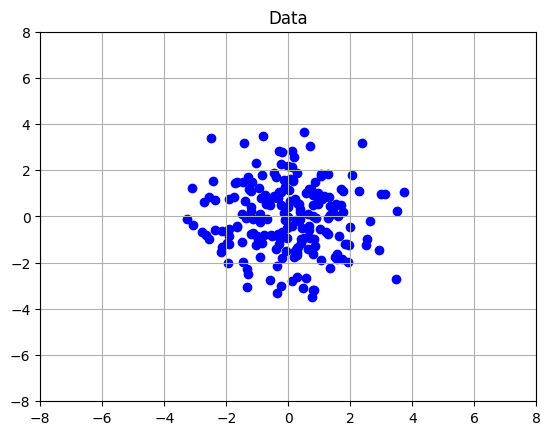

In [14]:
draw_data(data1.cpu(), title_str='Data')
lim = 8
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.grid(True)

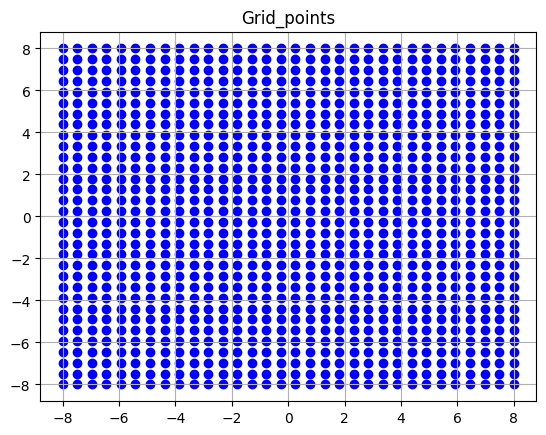

In [15]:
draw_data(grid_points.cpu(), title_str='Grid_points')
plt.grid(True)

In [16]:
# defining model
m1 = MyModel()

In [17]:
# 모델 학습
epochs = 500

losses = training_model(epochs, grid_points, data1, d, m1, device=device)

epoch: 0, loss: 46.94489288330078
epoch: 100, loss: 0.0524691678583622
epoch: 200, loss: 0.05134236440062523
epoch: 300, loss: 0.05216953530907631
epoch: 400, loss: 0.05014192312955856


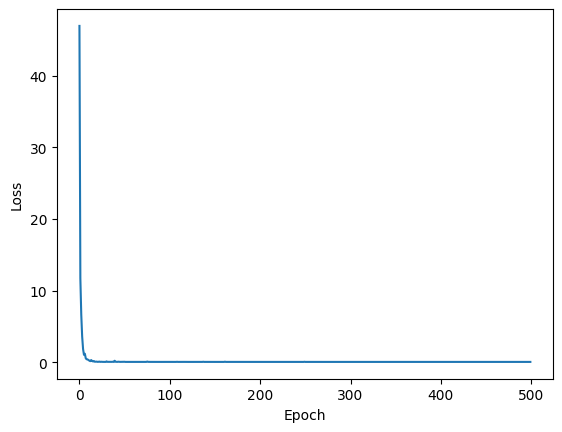

0.051891278475522995


In [18]:
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()
print(losses[-1])

In [ ]:
# PATH = './diffusive_flow.pth'
# torch.save(m.state_dict(), PATH)

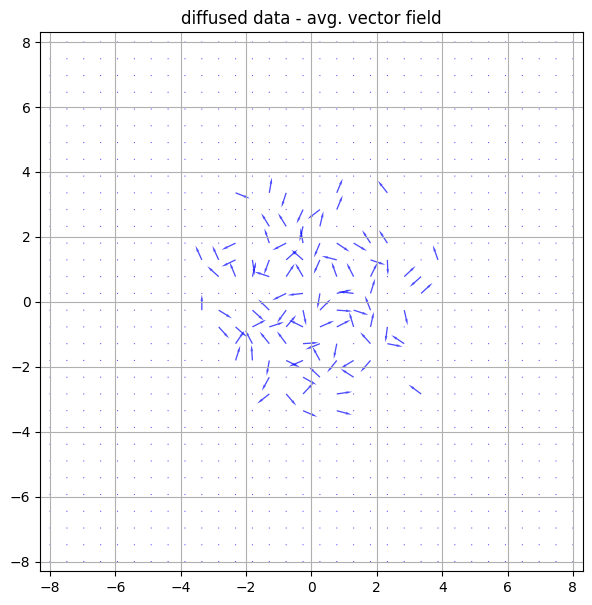

103


In [22]:
# diffused data (from t=0 to t=9) (비교용)
eta = torch.randn_like(data1).to(device)
x_curr = data1.to(device)
# for t in range(n_steps):
#     x_curr, v = make_vectors(d, x_curr, t)
x_curr, v = make_vectors(d, x_curr, 0)

vf = make_vector_field(grid_points, data1, v)

# for v in vf:
#     if(torch.norm(v) > 0):
#         print(torch.norm(v))

# v = x_curr.to(device) - data1.to(device)
# normalized_v = normalize_vector_field(v)

draw_vector_field(grid_points.cpu(), vf.cpu(), title_str="diffused data - avg. vector field")
# draw_vector_field(data1.cpu(), normalized_v.cpu(), lim=2, title_str="diffused data")
# draw_vector_field(data1.cpu(), v.cpu(), lim=3)
i = 0
for v in vf:
    if v.norm() > 0:
        i += 1
    
print(i)


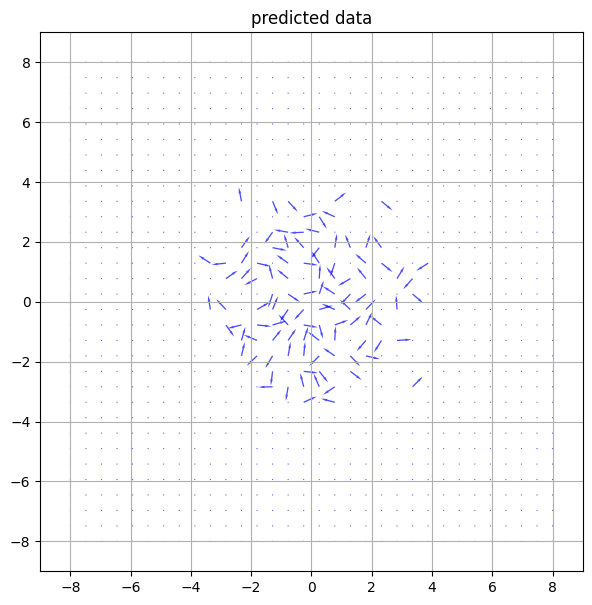

In [21]:
# MyModel prediction 결과
with torch.no_grad():
    outputs = m1(0)
    normalized_out = normalize_vector_field(outputs)
    
    # draw_vector_field(grid_points.cpu(), outputs.cpu(),lim=9, title_str="predicted data")
    draw_vector_field(grid_points.cpu(), normalized_out.cpu(),lim=9, title_str="predicted data")

    i = 0
    for v in normalized_out:
        if v.norm() > 0:
            i += 1
        
    print(i)

  

## Gaussian data (2)

In [ ]:
# generate a Gaussian data
dim = 2
datanum = 200
mean = np.array([7.5, 0])
cov = np.array([[0, 3],[0, 3]])

data2 = np.random.multivariate_normal(mean, cov, datanum)
data2 = torch.from_numpy(data2).float()

In [ ]:
draw_data(data2.cpu(), title_str='Data2')
lim = 8
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.grid(True)

In [ ]:
# defining model
m2 = MyModel()

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.SGD(m2.parameters(), lr=0.001)

In [ ]:
# 모델 학습
losses = losses = training_model(epochs, grid_points, data2, d, m2, device=device)

In [ ]:
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
# diffused data (from t=0 to t=9) (비교용)
eta = torch.randn_like(data2).to(device)
x_curr = data2.to(device)
# for t in range(n_steps):
#     x_curr, v = make_vectors(d, x_curr, t)
x_curr, v = make_vectors(d, x_curr, 0)

vf = make_vector_field(grid_points, data2, v)

# v = x_curr.to(device) - data2.to(device)
# normalized_v = normalize_vector_field(v)

draw_vector_field(grid_points.cpu(), vf.cpu(), title_str="diffused data - avg. vector field")
# draw_vector_field(data2.cpu(), normalized_v.cpu(), title_str="diffused data")
# draw_vector_field(data2.cpu(), v.cpu())

In [ ]:
with torch.no_grad():
    outputs = m2(0)
    normalized_out = normalize_vector_field(outputs)
    
    draw_vector_field(grid_points.cpu(), normalized_out.cpu(), title_str="predicted data")
    # draw_vector_field(data2.cpu(), outputs.cpu())
    